In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_size = 784
hidden_size = 128
num_classes = 10
learning_rate = 0.001
batch_size = 100
num_epochs = 10

train_dataset = datasets.MNIST(
  root="data", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
  root="data", train=False, transform=transforms.ToTensor()
)

# Data Loader
train_loader = DataLoader(
  dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
  dataset=test_dataset, batch_size=batch_size, shuffle=False
)

Using device: cpu


In [ ]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    # Define cully connected layers
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU() # avoid gradient vanishing
    # Define output layer
    self.fc2 = nn.Linear(hidden_size, output_size)
    
  def forward(self, x):
    # Flatten the input
    x = x.reshape(x.shape[0], -1)
    # Pass through the first layer
    out = self.fc1(x)
    out = self.relu(out)
    # Pass through the output layer
    out = self.fc2(out)
    return out
  
model = MLP(input_size, hidden_size, num_classes).to(device)

In [27]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss() # Module to compute the loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimizer

In [ ]:
# Function to train the model
def train(model, data_loader, criterion, optimizer, device):
  # Set the model to training mode
  model.train()

  # Initialize the loss and accuracy
  total_loss = 0.0
  correct = 0
  total = 0
  
  # Iterate over the data loader
  for batch_idx, (images, labels) in enumerate(data_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels) # Compute the loss
    
    # Backward pass and optimization
    loss.backward() # Compute the gradients
    optimizer.step() # Update the weights
    
    # Update the loss and accuracy
    total_loss += loss.item()
    
    # Calculate the accuracy
    _, predicted = outputs.max(1) # B, 10 (num classes)
    total += labels.size(0) # save the total number of samples
    correct += predicted.eq(labels).sum().item() # save the number of correct predictions
    
  # Calculate the average loss and accuracy
  avg_loss = total_loss / len(data_loader)
  avg_accuracy = 100. * correct / total
  
  return avg_loss, avg_accuracy

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate(model, data_loader, criterion, device):
  # Set the model to evaluation mode
  model.eval()
  
  # Initialize the loss and accuracy
  total_loss = 0.0
  correct = 0
  total = 0
  predicted_labels = []
  true_labels = []
  
  # Disable gradient calculation
  with torch.no_grad():
    for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)
      
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      total_loss += loss.item()

      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
      
      predicted_labels.extend(predicted.tolist())
      true_labels.extend(labels.tolist())
  
  avg_loss = total_loss / len(data_loader)
  avg_accuracy = 100. * correct / total
  
  precision = precision_score(true_labels, predicted_labels, average='macro') # Calculate precision
  recall = recall_score(true_labels, predicted_labels, average='macro') # Calculate sensitivity
  f1 = f1_score(true_labels, predicted_labels, average='macro') # Metrics that balances precision and recall
  
  return avg_loss, avg_accuracy, precision, recall, f1, predicted_labels, true_labels

In [ ]:
# Training loop
for epoch in range(num_epochs):
  train_loss, train_accuracy = train(model, train_loader, loss_fn, optimizer, device)
  val_loss, val_accuracy, precision, recall, f1, predicted_labels, true_labels = evaluate(model, test_loader, loss_fn, device)
  
  print(f"Epoch {epoch+1}/{num_epochs}")
  print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
  

Epoch 1/10
Train Loss: 0.3850, Train Accuracy: 89.64%
Epoch 2/10
Train Loss: 0.1807, Train Accuracy: 94.85%
Epoch 3/10
Train Loss: 0.1272, Train Accuracy: 96.34%
Epoch 4/10
Train Loss: 0.0969, Train Accuracy: 97.17%
Epoch 5/10
Train Loss: 0.0767, Train Accuracy: 97.81%
Epoch 6/10
Train Loss: 0.0625, Train Accuracy: 98.16%
Epoch 7/10
Train Loss: 0.0524, Train Accuracy: 98.43%
Epoch 8/10
Train Loss: 0.0437, Train Accuracy: 98.79%
Epoch 9/10
Train Loss: 0.0360, Train Accuracy: 98.95%
Epoch 10/10
Train Loss: 0.0302, Train Accuracy: 99.16%


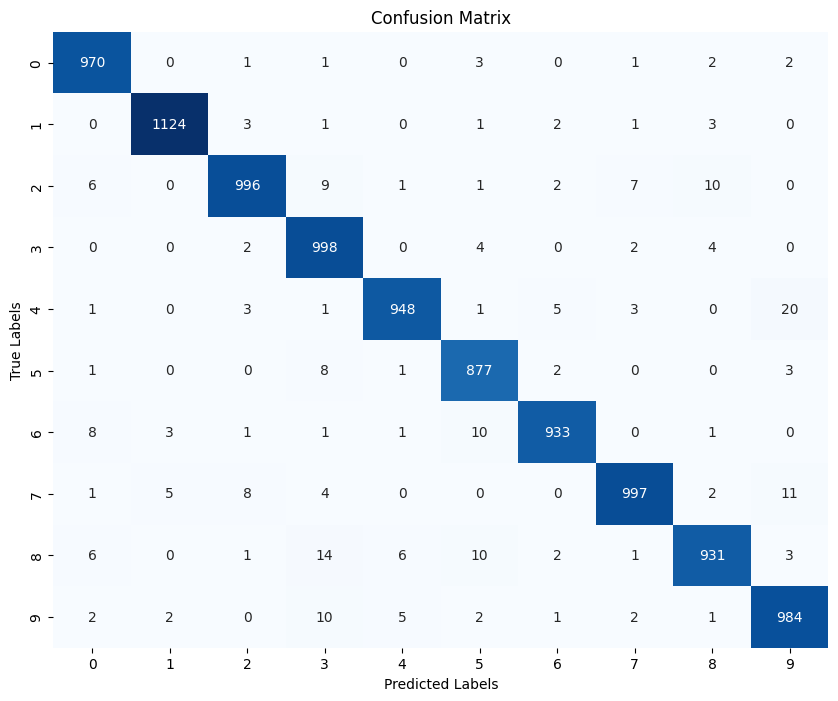

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

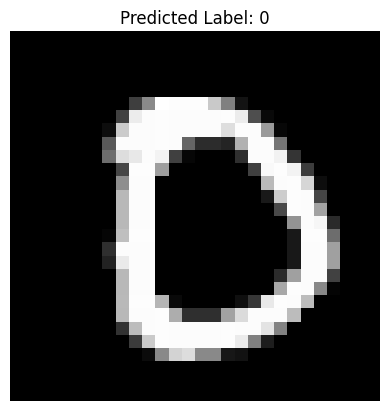

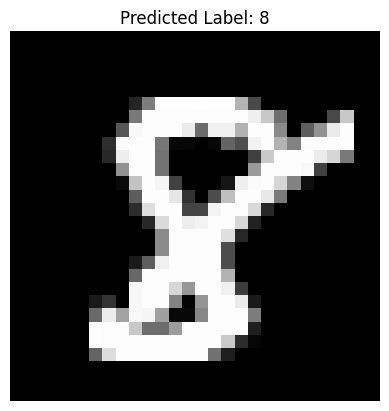

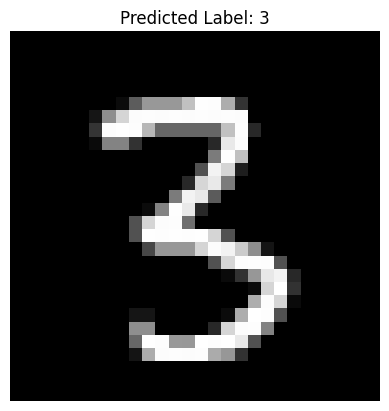

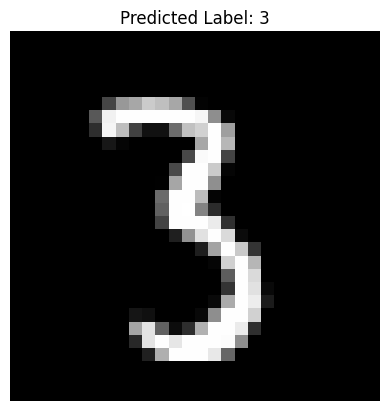

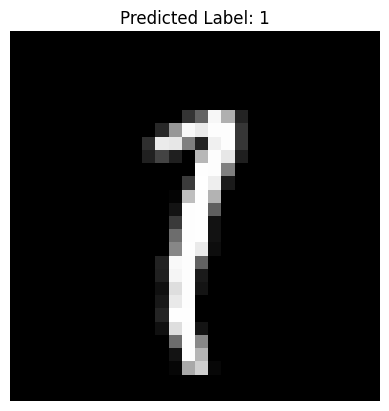

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Function to display the image and predicted label
def show_prediction(image, predicted_label):
    #plt.imshow nge show imagenya
    plt.imshow(image.squeeze(), cmap="gray") #C,H,W -> h,w
    #kita matikan axis supaya show imagenya lebih smooth
    plt.axis("off")
    #kemudian memberikan title predicted labelsnya
    plt.title(f"Predicted Label: {predicted_label}")
    plt.show()

# Specify the number of sample images to test
num_samples = 5

# Select random sample images from the test set
sample_indices = np.random.choice(len(test_dataset), num_samples, replace=False)

for index in sample_indices:
    sample_image, sample_label = test_dataset[index]
    sample_image = sample_image.to(device).unsqueeze(0) #karena input model menginginkan bentuk image kita dalam format B,

    # Make the prediction
    model.eval()#change mode model to eval
    with torch.no_grad():#ini adalah operasi untuk meringankan gpu kita
        output = model(sample_image)#output prediction dari model dengan input sample_img
        _, predicted = torch.max(output.data, 1)#kita dapat index maximum dari torch.max

    # Convert the tensor to a numpy array
    sample_image = sample_image.cpu().squeeze().numpy()#B,C,H,W -> C,H,W

    # Display the sample image and predicted label
    show_prediction(sample_image, predicted.item())